In [2]:
'''
以下代码将实现以下功能

1. 使用dlib对样本对图像进行人头裁剪（具体代码实现参考 utils.dlib_facedetect.py）
2. 使用matplotlib绘制样本对
3. 样本对预处理
4. 单样本对预测与输出
'''

'\n以下代码将实现以下功能\n\n1. 使用dlib对样本对图像进行人头裁剪（具体代码实现参考 utils.dlib_facedetect.py）\n2. 使用matplotlib绘制样本对\n3. 样本对预处理\n4. 单样本对预测与输出\n'

In [16]:
import matplotlib.pyplot as plt
import os
import cv2
import csv
import tensorflow as tf
import numpy as np
import random
from keras import backend as K
from keras.preprocessing.image import img_to_array
from keras.optimizers import SGD,RMSprop
from keras.models import Model, Sequential,load_model
from keras.layers import Input,Concatenate, Add,Subtract,Lambda
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam,RMSprop,SGD

In [17]:
#set GPU to memory-growth mode

gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [19]:
##same_person
image1='/root/tf-2.0/Siamese_Face_Detection/data/64_CASIA-FaceV5/479/479_1.bmp'
image2='/root/tf-2.0/Siamese_Face_Detection/data/64_CASIA-FaceV5/479/479_3.bmp'

##different person
image3='/root/tf-2.0/Siamese_Face_Detection/data/64_CASIA-FaceV5/060/060_1.bmp'
image4='/root/tf-2.0/Siamese_Face_Detection/data/64_CASIA-FaceV5/479/479_4.bmp'

image_list=[plt.imread(image1),plt.imread(image2),plt.imread(image3),plt.imread(image4)]

In [20]:
def plot_digits(data):
    fig, axes = plt.subplots(2, 2, figsize=(16, 16),
                             subplot_kw={'xticks':[], 'yticks':[]},
    gridspec_kw=dict(hspace=0.1, wspace=0.1)) 
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i])

    plt.show()

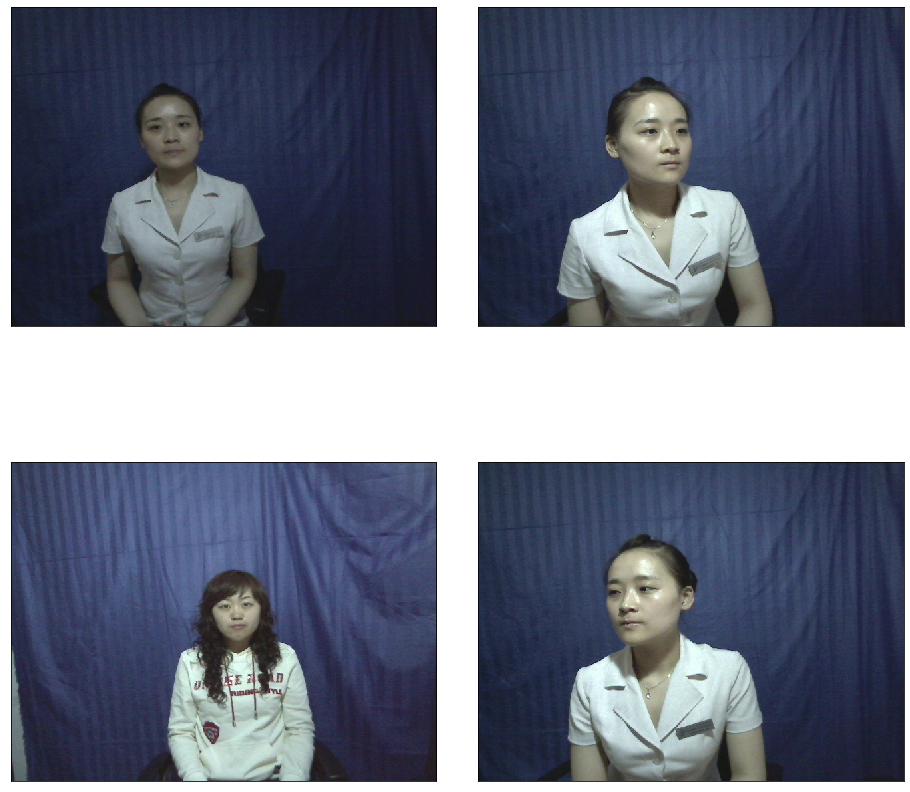

In [21]:
plot_digits(image_list)

In [22]:
#for training, using utils.dlib_facedetect.py to clip out the face

import numpy as np
import cv2
import dlib
import glob
import os

detector = dlib.get_frontal_face_detector()
image_path_list=[image1,image2,image3,image4]

image_clip=[]
for im_path in image_path_list:
    im_data = plt.imread(im_path)
    dets = detector(im_data, 1)
    print(dets)
    if dets.__len__() == 0:
        continue
    d = dets[0]
    x1 = d.left()
    y1 = d.top()
    x2 = d.right()
    y2 = d.bottom()

    y1 = int(y1 - (y2 - y1) * 0.3)
    x1 = int(x1 - (x2 - x1) * 0.05)
    x2 = int(x2 + (x2 - x1) * 0.05)
    y2 = y2

    im_crop_data = im_data[y1:y2,x1:x2]
    im_data = cv2.resize(im_crop_data, (160, 160))
    image_clip.append(im_data)


rectangles[[(195, 156) (285, 245)]]
rectangles[[(210, 139) (339, 268)]]
rectangles[[(308, 198) (370, 260)]]
rectangles[[(167, 139) (296, 268)]]


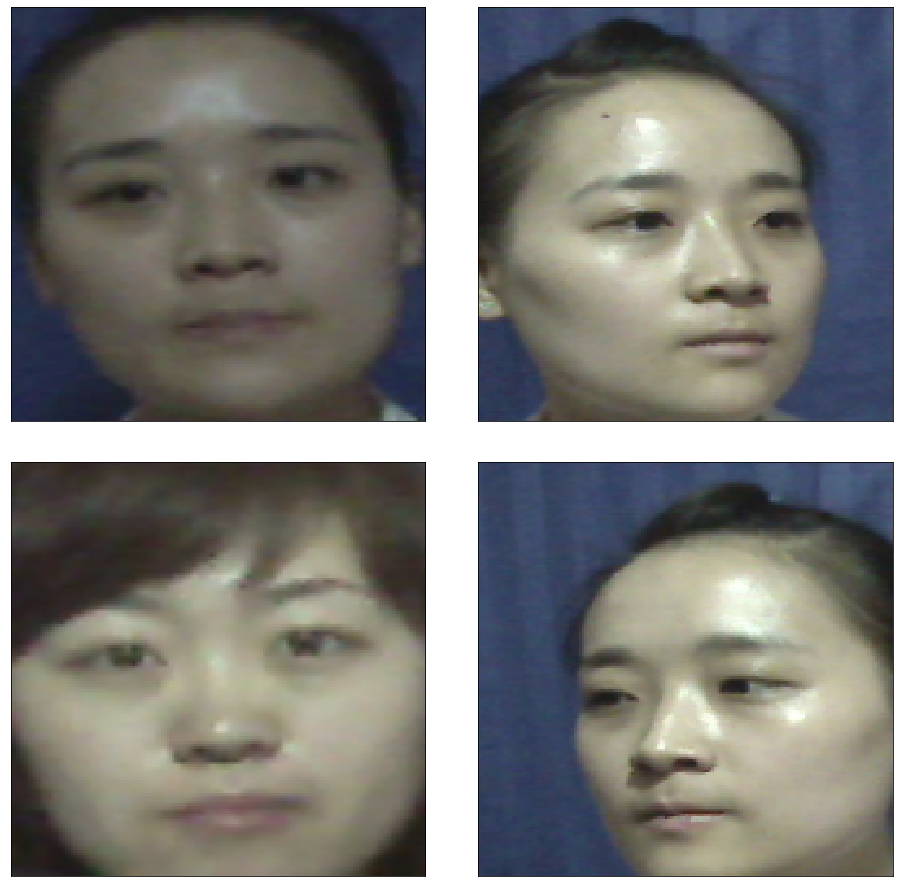

In [23]:
plot_digits(image_clip)

In [24]:
# calculate accuracy
def compute_accuracy(y_true, y_pred):
    pred = y_pred.ravel() < 0.9
    print('pred:', pred)
    return np.mean(pred == y_true)

# calculate loss
def contrastive_loss(y_true, y_pred):
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

Siamese_softmax_model=load_model('/root/tf-2.0/Siamese_Face_Detection/h5/Siamese_softmax_02.h5',
                                 custom_objects={'contrastive_loss':contrastive_loss})

In [25]:
Siamese_softmax_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 50)           248002      input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           model_1[1][0]              

In [26]:
pair1_0_same=np.expand_dims(image_clip[0]/255.,axis=0)
pair1_1_same=np.expand_dims(image_clip[1]/255.,axis=0)
pair1_0_diff=np.expand_dims(image_clip[2]/255.,axis=0)
pair1_1_diff=np.expand_dims(image_clip[3]/255.,axis=0)

In [32]:
y_pred=Siamese_softmax_model.predict([pair1_0_same,pair1_1_same])
pred=y_pred.ravel()<0.8
pred
print(y_pred,pred)

[[0.5887241]] [ True]


In [33]:
y_pred=Siamese_softmax_model.predict([pair1_0_diff,pair1_1_diff])
pred=y_pred.ravel()<0.8
print(y_pred,pred)

[[1.1139754]] [False]
